# 🎯 Predictions Demo - Incremental Predictions

Ce notebook démontre comment faire des prédictions incrémentales :
1. Prédire le classement à différents gameweeks
2. Visualiser l'évolution des prédictions
3. Comparer avec la réalité
4. Analyser la stabilité des prédictions

Cellule 2 (Code - Imports)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import json
from datetime import datetime

sys.path.append('..')
from src.models.predict import PredictionPipeline, predict_evolution

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Imports successful")

✅ Imports successful


## 1️⃣ Prédiction Simple à un Gameweek

Cellule 4 (Code - Prédiction simple)


In [2]:
# Créer le pipeline
pipeline = PredictionPipeline()

# Prédire au gameweek 20 de la saison 2022-2023 (test set)
season = '2022-2023'
gameweek = 20

predictions = pipeline.predict_and_save(season, gameweek)

✅ Models directory found: C:\Users\akram\OneDrive\Bureau\premier_league_mlops\models\production
🔍 Looking for model at: C:\Users\akram\OneDrive\Bureau\premier_league_mlops\models\production\latest_model.joblib
🔍 Looking for metadata at: C:\Users\akram\OneDrive\Bureau\premier_league_mlops\models\production\latest_metadata.json
✅ Loaded model: ensemble_stacking
   Timestamp: 20251212_215937
   Val MAE: 4.58
   Test MAE: 5.19

PREDICTING FINAL STANDINGS
Season: 2022-2023
After Gameweek: 20
Model: ensemble_stacking
Val MAE: 4.58
Test MAE: 5.19

📂 Chargement de toutes les données...
  ✓ Chargement: train.parquet
  ✓ Chargement: val.parquet
  ✓ Chargement: test.parquet
  Total: 4,640 lignes, 32 équipes
  Features: 38
📊 Data loaded: 20 teams
🔍 Target range: 25.0 to 89.0
🔍 Features utilisées: 38

🧪 Premières prédictions vs réalité:
   Arsenal                   Prédit:   89.0 | Réel:   84.0 | Erreur:    -5.0
   Manchester City           Prédit:   82.2 | Réel:   89.0 | Erreur:    +6.8
   Newcast

## 2️⃣ Évolution des Prédictions au Fil de la Saison

Cellule 6 (Code - Prédictions multiples)


In [3]:
# Prédire à plusieurs gameweeks
season = '2022-2023'
gameweeks = [10, 15, 20, 25, 30, 35, 38]

all_predictions = {}
for gw in gameweeks:
    print(f"\n🎯 Gameweek {gw}")
    pred = pipeline.predict_at_gameweek(season, gw)
    all_predictions[gw] = pred
    mae = pred['points_error'].abs().mean()
    print(f"   ✓ {len(pred)} teams predicted | MAE: {mae:.2f} points")


🎯 Gameweek 10

PREDICTING FINAL STANDINGS
Season: 2022-2023
After Gameweek: 10
Model: ensemble_stacking
Val MAE: 4.58
Test MAE: 5.19

📊 Data loaded: 20 teams
🔍 Target range: 25.0 to 89.0
🔍 Features utilisées: 38

🧪 Premières prédictions vs réalité:
   Manchester City           Prédit:   89.5 | Réel:   89.0 | Erreur:    -0.5
   Arsenal                   Prédit:   89.1 | Réel:   84.0 | Erreur:    -5.1
   Tottenham Hotspur         Prédit:   76.0 | Réel:   60.0 | Erreur:   -16.0
   ✓ 20 teams predicted | MAE: 9.22 points

🎯 Gameweek 15

PREDICTING FINAL STANDINGS
Season: 2022-2023
After Gameweek: 15
Model: ensemble_stacking
Val MAE: 4.58
Test MAE: 5.19

📊 Data loaded: 20 teams
🔍 Target range: 25.0 to 89.0
🔍 Features utilisées: 38

🧪 Premières prédictions vs réalité:
   Arsenal                   Prédit:   88.5 | Réel:   84.0 | Erreur:    -4.5
   Manchester City           Prédit:   87.6 | Réel:   89.0 | Erreur:    +1.4
   Newcastle United          Prédit:   70.3 | Réel:   71.0 | Erreur:    

Cellule 7 (Code - Préparation données évolution)


In [4]:
# Sélectionner quelques équipes à suivre
teams_to_track = [
    'Manchester City',
    'Arsenal', 
    'Manchester United',
    'Newcastle United',
    'Liverpool'
]

# Créer un DataFrame pour suivre l'évolution
evolution_data = []

for gw, pred_df in all_predictions.items():
    for team in teams_to_track:
        team_pred = pred_df[pred_df['team'] == team]
        if not team_pred.empty:
            evolution_data.append({
                'gameweek': gw,
                'team': team,
                'predicted_rank': team_pred.iloc[0]['predicted_rank'],
                'predicted_points': team_pred.iloc[0]['predicted_final_points']
            })

evolution_df = pd.DataFrame(evolution_data)
print("\n📊 Evolution Data:")
print(evolution_df.head(10))


📊 Evolution Data:
   gameweek               team  predicted_rank  predicted_points
0        10    Manchester City               1         89.541376
1        10            Arsenal               2         89.092645
2        10  Manchester United               5         64.409726
3        10   Newcastle United               7         59.249031
4        10          Liverpool               8         55.857322
5        15    Manchester City               2         87.607046
6        15            Arsenal               1         88.503799
7        15  Manchester United               5         63.044493
8        15   Newcastle United               3         70.279317
9        15          Liverpool               7         60.264824


Cellule 8 (Code - Visualisation évolution)


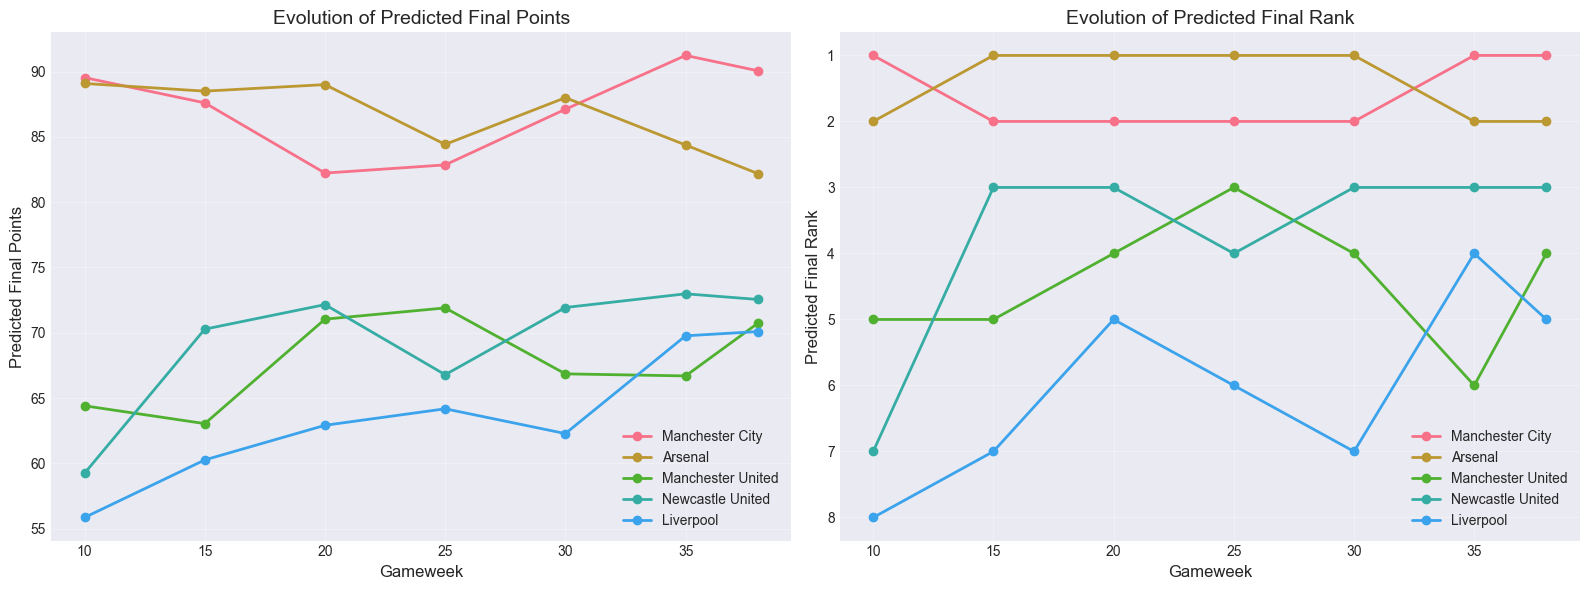

In [5]:
# Visualiser l'évolution des prédictions de points
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Évolution des points prédits
for team in teams_to_track:
    team_data = evolution_df[evolution_df['team'] == team]
    axes[0].plot(team_data['gameweek'], team_data['predicted_points'], 
                marker='o', label=team, linewidth=2)

axes[0].set_xlabel('Gameweek', fontsize=12)
axes[0].set_ylabel('Predicted Final Points', fontsize=12)
axes[0].set_title('Evolution of Predicted Final Points', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Évolution du classement prédit
for team in teams_to_track:
    team_data = evolution_df[evolution_df['team'] == team]
    axes[1].plot(team_data['gameweek'], team_data['predicted_rank'], 
                marker='o', label=team, linewidth=2)

axes[1].set_xlabel('Gameweek', fontsize=12)
axes[1].set_ylabel('Predicted Final Rank', fontsize=12)
axes[1].set_title('Evolution of Predicted Final Rank', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].invert_yaxis()  # Rank 1 en haut

plt.tight_layout()
plt.show()

## 3️⃣ Stabilité des Prédictions

Cellule 10 (Code - Analyse stabilité)



📊 Prediction Stability (Lower Std = More Stable):
                   Avg_Points  Std_Points  Avg_Rank  Std_Rank
team                                                         
Liverpool               63.62        5.06      6.00      1.41
Newcastle United        69.42        4.96      3.71      1.50
Manchester City         87.24        3.51      1.57      0.53
Manchester United       67.81        3.47      4.43      0.98
Arsenal                 86.52        2.79      1.43      0.53


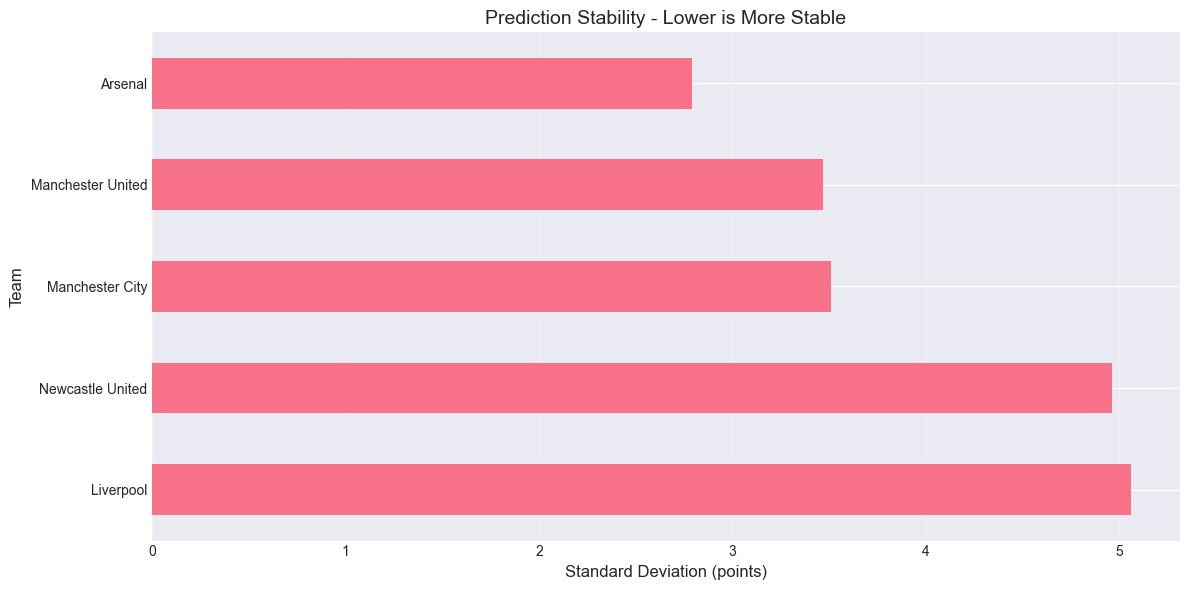

In [6]:
# Calculer la volatilité des prédictions (écart-type sur les gameweeks)
volatility = evolution_df.groupby('team').agg({
    'predicted_points': ['mean', 'std'],
    'predicted_rank': ['mean', 'std']
}).round(2)

volatility.columns = ['Avg_Points', 'Std_Points', 'Avg_Rank', 'Std_Rank']
volatility = volatility.sort_values('Std_Points', ascending=False)

print("\n📊 Prediction Stability (Lower Std = More Stable):")
print(volatility)

# Visualiser
fig, ax = plt.subplots(figsize=(12, 6))
volatility['Std_Points'].plot(kind='barh', ax=ax)
ax.set_xlabel('Standard Deviation (points)', fontsize=12)
ax.set_ylabel('Team', fontsize=12)
ax.set_title('Prediction Stability - Lower is More Stable', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 4️⃣ Comparaison : Prédiction Précoce vs Tardive

Cellule 12 (Code - Comparaison GW10 vs GW38)


In [7]:
# Comparer prédictions au GW 10 vs GW 38 vs Réalité
if 10 in all_predictions and 38 in all_predictions:
    early_pred = all_predictions[10][['team', 'predicted_rank', 'predicted_final_points']].copy()
    early_pred.columns = ['team', 'rank_gw10', 'points_gw10']
    
    late_pred = all_predictions[38][['team', 'predicted_rank', 'predicted_final_points']].copy()
    late_pred.columns = ['team', 'rank_gw38', 'points_gw38']
    
    # Ajouter la réalité si disponible
    if 'actual_final_points' in all_predictions[38].columns:
        actual = all_predictions[38][['team', 'actual_rank', 'actual_final_points']].copy()
        
        comparison = early_pred.merge(late_pred, on='team').merge(actual, on='team')
        comparison['improvement'] = (
            comparison['points_gw10'] - comparison['actual_final_points']
        ).abs() - (
            comparison['points_gw38'] - comparison['actual_final_points']
        ).abs()
        
        comparison = comparison.sort_values('actual_rank')
        
        print("\n📊 Comparison: Early (GW10) vs Late (GW38) vs Actual:")
        print(f"\n{'Team':<25} {'GW10':<8} {'GW38':<8} {'Actual':<8} {'Improvement':<12}")
        print("-"*70)
        
        for _, row in comparison.iterrows():
            improvement_emoji = "✅" if row['improvement'] > 0 else "⚠️"
            print(f"{row['team']:<25} {row['points_gw10']:<8.1f} {row['points_gw38']:<8.1f} "
                  f"{row['actual_final_points']:<8.1f} {row['improvement']:+12.1f} {improvement_emoji}")
        
        # Statistiques
        mae_early = (comparison['points_gw10'] - comparison['actual_final_points']).abs().mean()
        mae_late = (comparison['points_gw38'] - comparison['actual_final_points']).abs().mean()
        
        print(f"\n📊 Summary:")
        print(f"   MAE at GW10: {mae_early:.2f} points")
        print(f"   MAE at GW38: {mae_late:.2f} points")
        print(f"   Improvement: {mae_early - mae_late:+.2f} points ({(mae_early - mae_late)/mae_early*100:+.1f}%)")


📊 Comparison: Early (GW10) vs Late (GW38) vs Actual:

Team                      GW10     GW38     Actual   Improvement 
----------------------------------------------------------------------
Manchester City           89.5     90.1     89.0             -0.5 ⚠️
Arsenal                   89.1     82.2     84.0             +3.3 ✅
Manchester United         64.4     70.7     75.0             +6.3 ✅
Newcastle United          59.2     72.6     71.0            +10.2 ✅
Liverpool                 55.9     70.1     67.0             +8.0 ✅
Brighton & Hove Albion    63.4     65.8     62.0             -2.4 ⚠️
Aston Villa               41.1     57.5     61.0            +16.4 ✅
Tottenham Hotspur         76.0     59.4     60.0            +15.4 ✅
Brentford                 45.9     58.1     59.0            +12.2 ✅
Fulham                    47.2     52.2     52.0             +4.5 ✅
Crystal Palace            44.4     45.5     45.0             +0.1 ✅
Chelsea                   67.5     46.2     44.0          

## 5️⃣ Visualisation Finale : Heatmap des Prédictions

Cellule 14 (Code - Heatmap)


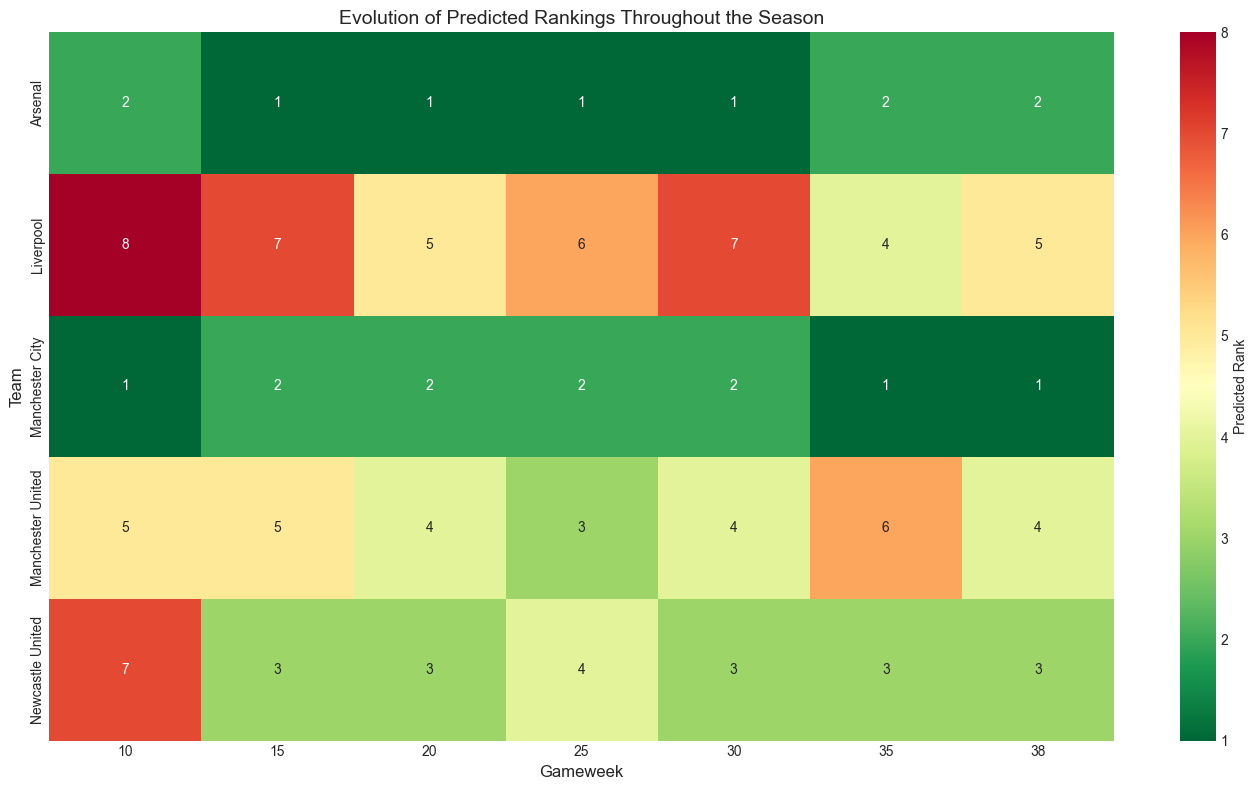

In [8]:
# Créer une heatmap des classements prédits
pivot_data = evolution_df.pivot(index='team', columns='gameweek', values='predicted_rank')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Predicted Rank'})
plt.title('Evolution of Predicted Rankings Throughout the Season', fontsize=14)
plt.xlabel('Gameweek', fontsize=12)
plt.ylabel('Team', fontsize=12)
plt.tight_layout()
plt.show()

## 6️⃣ Export pour Présentation

Cellule 16 (Code - Export et résumé)


In [9]:
# Sauvegarder les données d'évolution
output_dir = Path('../predictions/analysis')
output_dir.mkdir(parents=True, exist_ok=True)

evolution_df.to_csv(output_dir / f'{season}_evolution.csv', index=False)
print(f"✅ Evolution data saved to {output_dir / f'{season}_evolution.csv'}")

# Résumé
print("\n" + "="*70)
print("PREDICTION DEMO COMPLETE")
print("="*70)
print(f"\n📊 Summary:")
print(f"   Season analyzed: {season}")
print(f"   Gameweeks tracked: {len(gameweeks)}")
print(f"   Teams tracked: {len(teams_to_track)}")
print(f"   Most stable predictions: {volatility.index[0]}")
print(f"   Most volatile predictions: {volatility.index[-1]}")
print("\n✅ Ready for production predictions!")

✅ Evolution data saved to ..\predictions\analysis\2022-2023_evolution.csv

PREDICTION DEMO COMPLETE

📊 Summary:
   Season analyzed: 2022-2023
   Gameweeks tracked: 7
   Teams tracked: 5
   Most stable predictions: Liverpool
   Most volatile predictions: Arsenal

✅ Ready for production predictions!
